### Import statements

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

### Read and process original voltage signal

,time,V_ai0,V_ai1,V_ai2
0,0.00,0.291183,0.175329,1.489082
1,0.03,0.288637,0.185512,1.478899
2,0.06,0.291183,0.185512,1.483991
3,0.09,0.286091,0.182966,1.483991
4,0.12,0.283546,0.180421,1.491628
...,...,...,...,...
1995,59.85,0.326820,0.160056,2.624494
1996,59.88,0.321729,0.165147,2.627039
1997,59.91,0.329365,0.231332,2.604127
1998,59.94,0.319183,0.228786,2.634677


(0.0, 20.0)

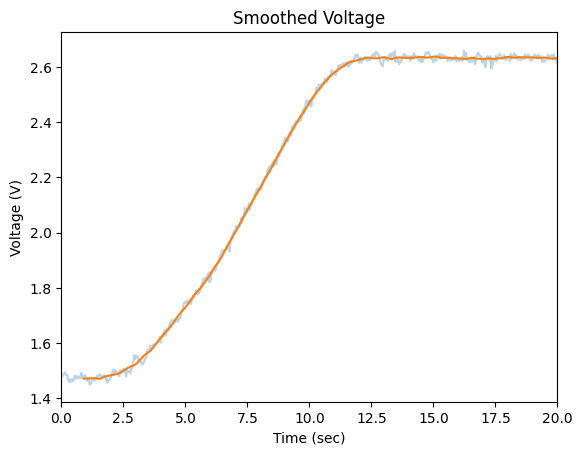

In [101]:
# process csv
filename = f'sensor_data/2025-02-01_19-40-41_sensor_data.csv'
df = pd.read_csv(filename)
display(df)

t = np.array(df['time'].values)
t_original = t
V_original = df['V_ai2']

# smooth data
window = 30
V_smooth = np.array(df['V_ai2'].rolling(window, center=True).mean().values)
V_smooth = V_smooth[window:]  # cut off nan values
t = t[window:]                # cut t to same size as V_smooth

# plot voltage over time
plt.plot(t_original, df['V_ai2'], alpha=0.3)
plt.plot(t, V_smooth)
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (V)')
plt.title('Smoothed Voltage')
plt.xlim(0, 20)

### Relevant methods

In [104]:
def V_to_htank(V):              # convert voltage to height
    return 2.3017*V + 4.3401

def approx_dVdt(t,V):           # calculate dV/dt
    dt = t[1]-t[0]
    #np.insert(V, 0, V[0])
    #np.insert(V, -1, V[-1])
    dVdt = np.zeros(len(V))
    for k in range(1,len(t)-1):
        dVdt[k] = (V[k+1] - V[k-1])/(2*dt)
    return dVdt

def flow_rate(dVdt, A):         # calculate flow rate
    return 2.3017*dVdt*A

In [105]:
def flow_series(Q, t, h = 1):
    # Q = flow rate data (array)
    # t = time data (array)
    # h = time step for SWMM time series, in sec
    pts_per_h = int(h/(t[1] - t[0]))
    flow_series = [0]
    k = 0
    dt = [datetime.datetime(2024, 1, 1, 0, 0, 0)]
    for i in range(0, len(Q)-pts_per_h, pts_per_h):
        k += 1
        sum = 0
        for j in range(i, i+pts_per_h):
            sum += Q[j]
        if sum < 0:
            sum = 0
        flow_series.append(sum/pts_per_h)
        dt.append(datetime.datetime(2024, 1, 1, 0, 0, k))
    return (np.array(flow_series), dt)


### Voltage to depth

(0.0, 30.0)

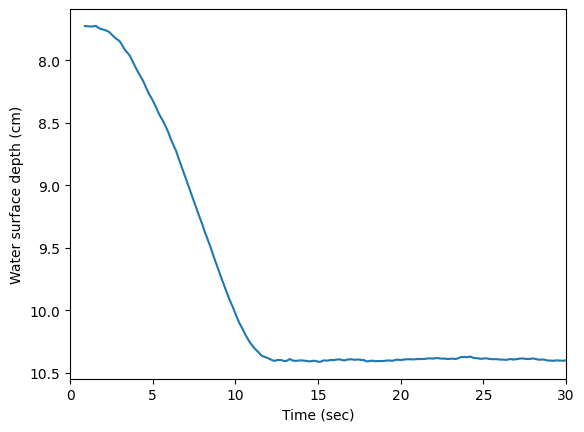

In [103]:
# plot water surface depth vs time

plt.plot(t, V_to_htank(V_smooth))
plt.gca().invert_yaxis()
plt.xlabel('Time (sec)')
plt.ylabel('Water surface depth (cm)')
plt.xlim(0,30)

### Calculate dV/dt

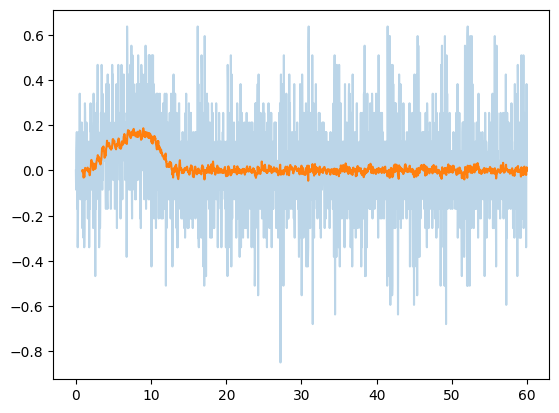

In [75]:
h = 1
t_sample = t[::h]
V_sample = V_smooth[::h]

dVdt = approx_dVdt(t_sample, V_sample)
dVdt_unsmooth = approx_dVdt(t_original, V_original)

plt.plot(t_original, dVdt_unsmooth, alpha=0.3)
plt.plot(t_sample, dVdt)

### Final visualization

In [106]:
# calculate flow rate

tank_OC = 57.75 # inches
thickness = 0.125 # inches
tank_OD = 57.75/np.pi # inches
tank_ID = (tank_OD - 2*thickness)*2.54 # cm
tank_A = 0.25*np.pi*(tank_ID**2)

Q = 2.3017*dVdt*tank_A
Q_unsmooth = 2.3017*dVdt_unsmooth*tank_A

Text(0, 0.5, 'Flow rate (mL/s)')

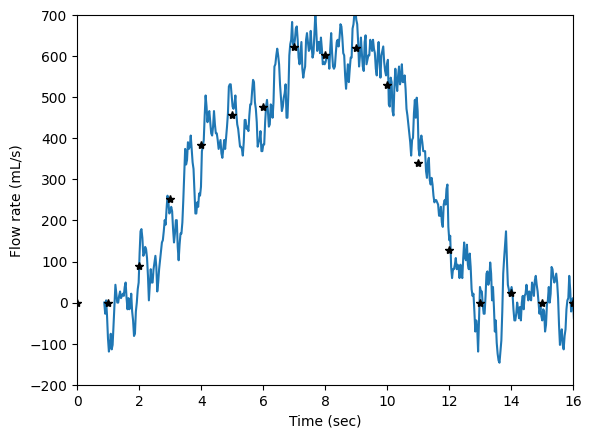

In [107]:
window2 = 30
dfq = pd.DataFrame({'Time': t_sample, 'Flow': Q})
Q_smooth = np.array(dfq['Flow'].rolling(window2).mean().values)

t_smooth = t_sample[window2-1:]
Q_smooth = Q_smooth[window2-1:]

(time_Q, time_t) = flow_series(Q, t_sample)
#print(time_t)
time_t = np.arange(0, len(time_Q))

#time_Q_unsmooth = flow_series(Q_unsmooth, t_original)
#time_t_unsmooth = np.arange(0, len(time_Q_unsmooth))

#plt.plot(t_original, Q_unsmooth, alpha = 0.3)
plt.plot(t_sample, Q)
#plt.plot(t_smooth, Q_smooth)
plt.plot(time_t, time_Q, 'k*')
#plt.plot(time_t_unsmooth, time_Q_unsmooth, 'r*') # better to smooth original voltage
plt.xlim(0,16)
plt.ylim(-200, 700)
plt.xlabel('Time (sec)')
plt.ylabel('Flow rate (mL/s)')

### Calculate total volumes to check method accuracy

In [ ]:
# calculate flow volume

def trap(t, Q):
  '''
  t = array of time values
  Q = flow rate values
  '''
  total = 0
  for i in range(len(t) - 1):
      h = t[i+1] - t[i]
      inc = (h/2)*(Q[i+1] + Q[i])
      total = total + inc
  return total

def simpson(t, Q):
  total = 0
  for i in range(0, len(t) - 2, 2):
      h = t[i+1] - t[i]
      inc = (h/3)*(Q[i] + 4*Q[i+1] + Q[i+2])
      total = total + inc
  return total

vol_trap = trap(t_sample, Q)
vol_simpson = simpson(t_sample, Q)
print(f'Calculated volume from trapezoidal integration: {vol_trap}')
print(f'Calculated volume from Simpson\'s 1/3 rule: {vol_simpson}')

Calculated volume from trapezoidal integration: 1388.9101943237772
Calculated volume from Simpson's 1/3 rule: 1370.6825345294224
